In [1]:
import os 
from time import time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import inception_v3
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing

import sklearn.metrics as metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import scipy.misc
import cv2

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# import zipfile
# import csv

## **Load the dataset**

In [3]:
train_dir = '../data/training_data/'
val_dir = '../data/validation_data/'
test_dir = '../data/testing_data/'

## **Data Augmentation**

In [4]:
training_batch_size = 8
validation_batch_size = 8
def get_images(img_size, preprocessing):

  
  train_datagen = ImageDataGenerator(rotation_range=20,
                                     horizontal_flip= True,
                                     vertical_flip=True,
                                     height_shift_range=0.1,
                                     width_shift_range=0.1,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     fill_mode="nearest",
                                     preprocessing_function = preprocessing)
  
  datagen = ImageDataGenerator(preprocessing_function= preprocessing)
  
  train_datagen = train_datagen.flow_from_directory(train_dir,
                                                    batch_size= training_batch_size,
                                                    shuffle= True,
                                                    target_size = (img_size, img_size),
                                                    classes = ['Disturbed', 'Undisturbed'])
  
  val_datagen = datagen.flow_from_directory(val_dir,
                                            batch_size= validation_batch_size,
                                            shuffle= False,
                                            target_size = (img_size, img_size),
                                            classes = ['Disturbed', 'Undisturbed'])
  
  test_datagen = datagen.flow_from_directory(test_dir,
                                            batch_size= validation_batch_size,
                                            shuffle= False,
                                            target_size = (img_size, img_size),
                                            classes = ['Disturbed', 'Undisturbed'])
  
  return train_datagen, val_datagen, test_datagen

In [5]:
train_datagen, val_datagen, test_datagen = get_images(300, preprocessing= inception_v3.preprocess_input)

Found 220 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


In [6]:
def visualize_training(history, epochs):
    fig = plt.figure(figsize=(16,12))
    plt.plot(history.history['accuracy']);
    plt.plot(history.history['val_accuracy'])
    plt.title("Model Accuracy")
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    label_1 = "{:.2f}".format(history.history['accuracy'][-1])
    label_2 = "{:.2f}".format(history.history['val_accuracy'][-1])
    plt.annotate(label_1, (epochs-1,history.history['accuracy'][-1]), textcoords="offset points", xytext=(0,10),ha='center')
    plt.annotate(label_2, (epochs-1,history.history['val_accuracy'][-1]), textcoords="offset points", xytext=(0,10),ha='center')
    plt.legend(['training', 'validation'], loc='upper left')

    fig = plt.figure(figsize=(16,12))
    plt.plot(history.history['loss']);
    plt.plot(history.history['val_loss'])
    plt.title("Model Loss")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    label_3 = "{:.2f}".format(history.history['loss'][-1])
    label_4 = "{:.2f}".format(history.history['val_loss'][-1])
    plt.annotate(label_3, (epochs-1,history.history['loss'][-1]), textcoords="offset points", xytext=(0,10),ha='center')
    plt.annotate(label_4, (epochs-1,history.history['val_loss'][-1]), textcoords="offset points", xytext=(0,10),ha='center')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

In [7]:
def print_classification_report(model, data_gen, batch_size):
    true_labels = data_gen.labels
    data_gen.reset()
    predicted_labels = model.predict(data_gen, steps = np.ceil(len(true_labels)/batch_size))
    #print(list( np.argmax(a) for a in predicted_labels), true_labels)
    print(classification_report(true_labels, list( np.argmax(a) for a in predicted_labels)))
    print("Confusion Matrix:\n ",confusion_matrix(true_labels,list( np.argmax(a) for a in predicted_labels)))

## **Build the model**

In [10]:
inception_base = inception_v3.InceptionV3(weights='imagenet', include_top= False, input_shape= (300, 300, 3))

In [11]:
#inception_base.summary()

In [12]:
model = models.Sequential()
model.add(inception_base)
model.add(keras.layers.GlobalAveragePooling2D())
#model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(512, activation='relu'))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(2, activation= 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 5

In [13]:
inception_base.trainable = False
inception_base.training = False

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 5

## **Compile the model**

In [15]:
learning_rate = 1e-4
model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate, 
                                             momentum=0.9, 
                                             nesterov= False), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [17]:
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath = '../models/inception-model.h5',
                                                  monitor = 'val_accuracy',
                                                  verbose=1,
                                                  save_best_only = True),
                  keras.callbacks.EarlyStopping(monitor= 'val_accuracy',
                                                patience = 6,
                                                mode = 'max',
                                                verbose= 1)
                 ]

## **Train the model**

In [18]:
n_epochs = 4
history = model.fit(train_datagen,
                    steps_per_epoch=len(train_datagen.filenames)//training_batch_size,
                    epochs=n_epochs,
                    validation_data=val_datagen,
                    validation_steps = int(np.ceil(len(val_datagen.filenames)/validation_batch_size)))

Epoch 1/4
27/27 [==============================] - 8s 172ms/step - loss: 0.7929 - accuracy: 0.5009 - val_loss: 0.6261 - val_accuracy: 0.6375
Epoch 2/4
27/27 [==============================] - 4s 131ms/step - loss: 0.7497 - accuracy: 0.5563 - val_loss: 0.5836 - val_accuracy: 0.7375
Epoch 3/4
27/27 [==============================] - 4s 136ms/step - loss: 0.7562 - accuracy: 0.5439 - val_loss: 0.5604 - val_accuracy: 0.7750
Epoch 4/4
27/27 [==============================] - 4s 130ms/step - loss: 0.6631 - accuracy: 0.5856 - val_loss: 0.5396 - val_accuracy: 0.7750


## **Fine tune the model**

In [20]:
inception_base.trainable = True

for layer in inception_base.layers[:249]:
    set_trainable = False
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable= False

In [21]:
for layer in inception_base.layers[249:]:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [22]:
#for i, layer in enumerate(inception_base.layers):
#    print(i, layer.name, layer.trainable)

In [25]:
learning_rate = 1e-4
model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate, 
                                             momentum=0.9, 
                                             nesterov = False), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 5

In [26]:
n_epochs = 40
history = model.fit(train_datagen,
                    steps_per_epoch=len(train_datagen.filenames)//training_batch_size,
                    epochs=n_epochs,
                    validation_data=val_datagen,
                    validation_steps=int(np.ceil(len(val_datagen.filenames)/validation_batch_size)),
                    callbacks=callbacks_list,
                    verbose= 1)

Epoch 1/40
27/27 [==============================] - 7s 165ms/step - loss: 0.6365 - accuracy: 0.6522 - val_loss: 0.4969 - val_accuracy: 0.7875

Epoch 00001: val_accuracy improved from -inf to 0.78750, saving model to ../models/inception-model.h5
Epoch 2/40
27/27 [==============================] - 4s 134ms/step - loss: 0.6076 - accuracy: 0.6963 - val_loss: 0.4056 - val_accuracy: 0.8500

Epoch 00002: val_accuracy improved from 0.78750 to 0.85000, saving model to ../models/inception-model.h5
Epoch 3/40
27/27 [==============================] - 4s 131ms/step - loss: 0.5355 - accuracy: 0.7332 - val_loss: 0.3725 - val_accuracy: 0.8500

Epoch 00003: val_accuracy did not improve from 0.85000
Epoch 4/40
27/27 [==============================] - 4s 135ms/step - loss: 0.4483 - accuracy: 0.8189 - val_loss: 0.3189 - val_accuracy: 0.8625

Epoch 00004: val_accuracy improved from 0.85000 to 0.86250, saving model to ../models/inception-model.h5
Epoch 5/40
27/27 [==============================] - 4s 131ms/

## **Visualize the training process**

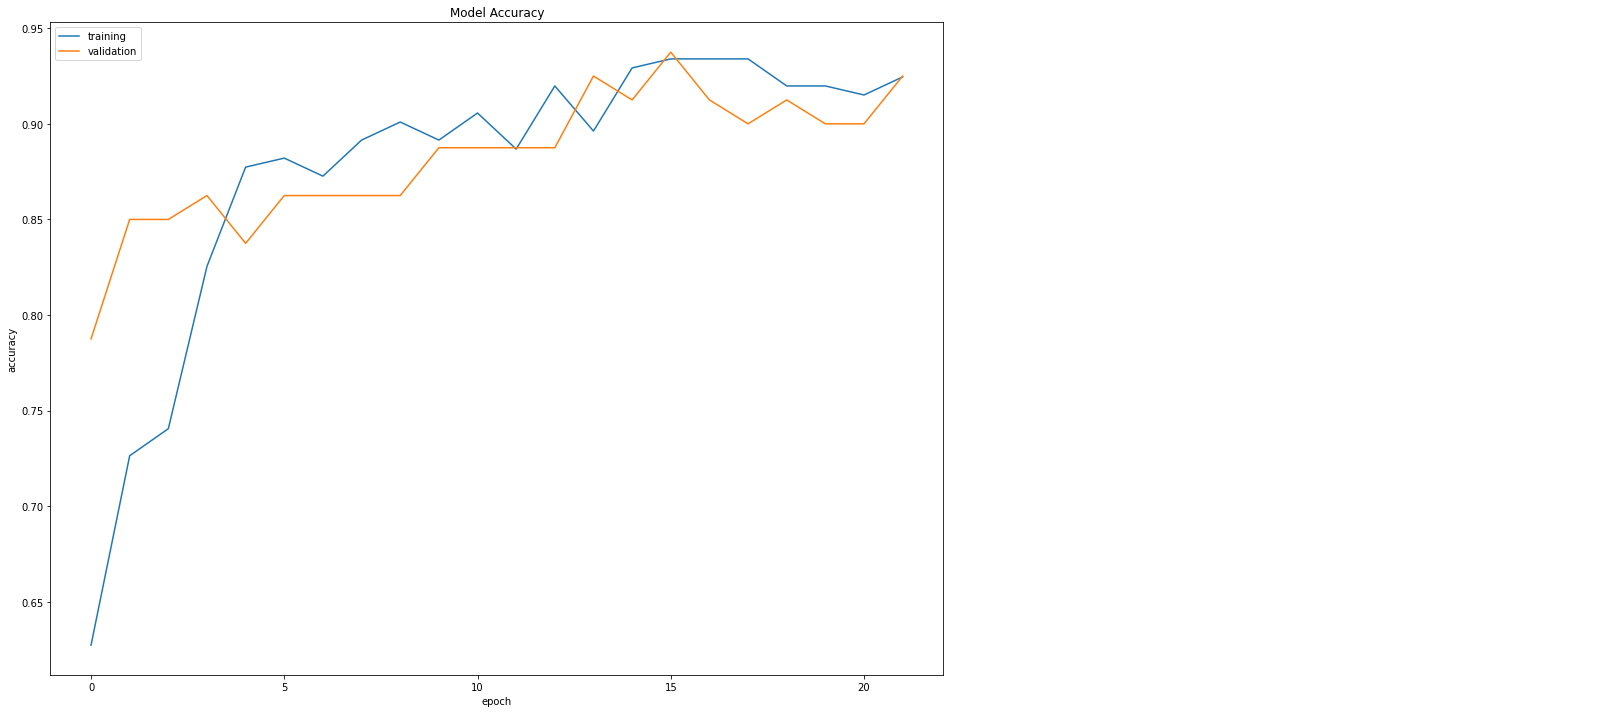

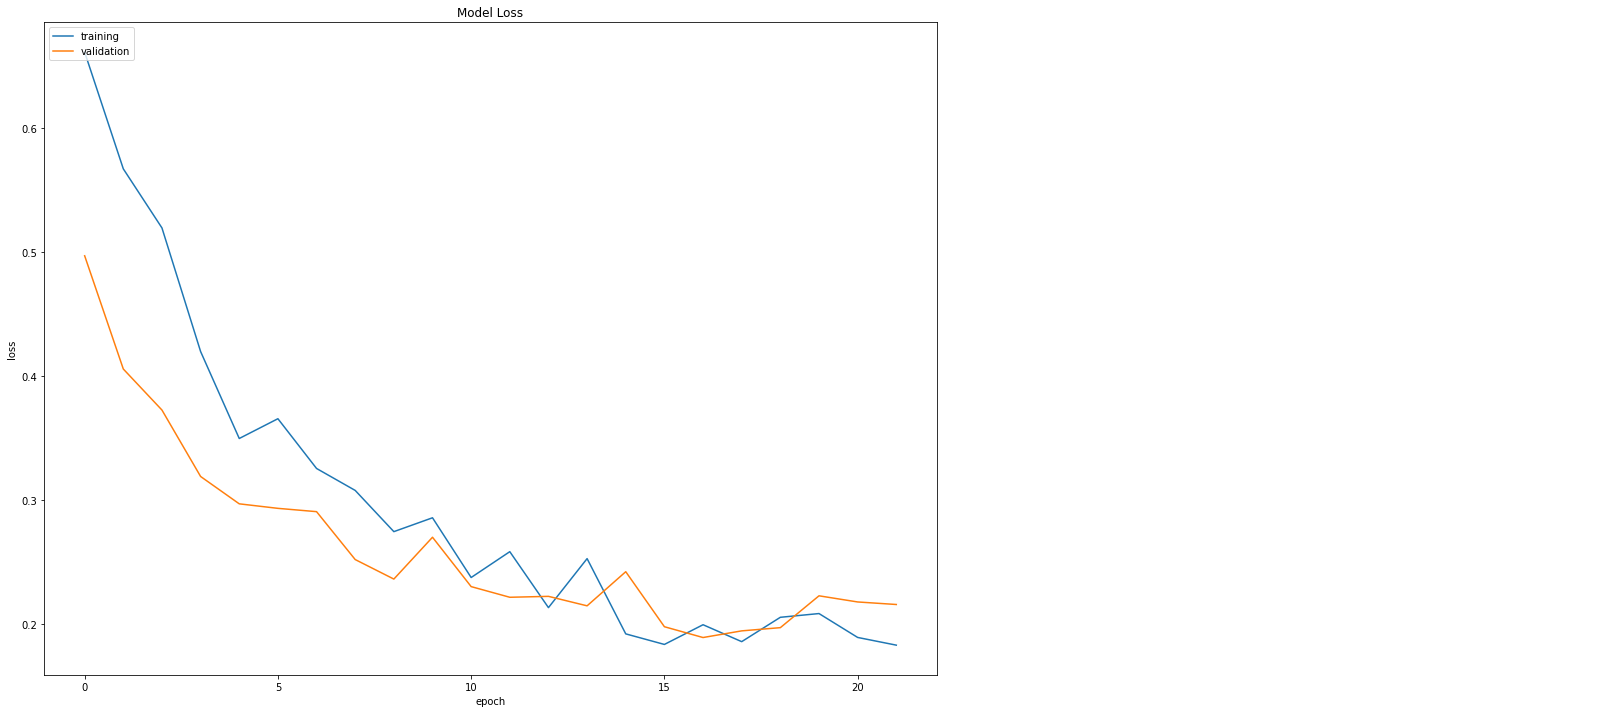

In [27]:
visualize_training(history, n_epochs)

## **Load the saved model**

In [28]:
loaded_model = load_model('../models/inception-model.h5')

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 5

## **Evaluate the model**

In [30]:
_, evaluate_datagen, test_datagen = get_images(299, preprocessing= inception_v3.preprocess_input)

Found 220 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


In [31]:
model_result = loaded_model.evaluate(evaluate_datagen, steps= None)

10/10 [==============================] - 1s 30ms/step - loss: 0.1843 - accuracy: 0.9250


In [32]:
test_report = loaded_model.evaluate(test_datagen, steps= None)

6/6 [==============================] - 0s 28ms/step - loss: 0.1771 - accuracy: 0.9091


## **Classification Report**

In [33]:
print_classification_report(loaded_model, evaluate_datagen,  validation_batch_size)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93        45
           1       0.94      0.89      0.91        35

    accuracy                           0.93        80
   macro avg       0.93      0.92      0.92        80
weighted avg       0.93      0.93      0.92        80

Confusion Matrix:
  [[43  2]
 [ 4 31]]


In [34]:
print_classification_report(loaded_model, test_datagen, validation_batch_size)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        26
           1       1.00      0.78      0.88        18

    accuracy                           0.91        44
   macro avg       0.93      0.89      0.90        44
weighted avg       0.92      0.91      0.91        44

Confusion Matrix:
  [[26  0]
 [ 4 14]]
